# GEOG5990M Final Assignment

Student ID number: 201775997

This is the final project of the GEOG5990 which will aim to find an association between the fuel poverty and the car availability of the households in LEEDS.In the first part of the project will install and import the required packages in order to develop the process.

In [2]:
# read in required packages
!pip install contextily
!pip install geoplot
!pip install mapclassify
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
import contextily as ctx
import seaborn as sns

import geoplot as gplt
import geoplot.crs as gcrs
gpd.datasets.available
from sklearn import cluster
from sklearn.preprocessing import scale

# set seaborn plotting theme to white
sns.set_theme(style="white")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 47.4 MB/s eta 0:00:00


The first dataset that was used in this project is the LSOA data cover the England and wales from DLUCH GIS Team <a href="#ref2">[2]</a>.I have made some change to the original dataset through ArcGIS Pro, which clipped the original dataset with the Leeds boundaries. But we can also accomplished this by finding str 'Leeds' in LSOA code using code leeds_shp =shp.loc[shp['lsoa11nm'].str.contains('Leeds'),:]. And the second dataset using is car or van availability from Office for National Statistics<a href="#ref3">[3]</a>. The last one is the fuel poverty from Data Mill North <a href="#ref1">[1]</a>. This three dataset consists of spatial and non-spatial data which can help us to find the association between fuel poverty and car availability in Leeds.

In the following few code cells will focus on the data exploring and cleaning, For the first LSOA shapefile dataset, the only thing useful that I have picked is geometry, LSOA code and name, Because this is the only sptail dataset we have, we need the LSOA code or name to joining the non-spatial data and geometry to show the final result spatially. For the car and van availability dataset, I have drop the observation column which is the replicates of the number of car data. For the fuel poverty data, I have drop three irrelevant columns. Also, drop the rows with nah value is also important when we dealing with three datasets.   


In [3]:

# Read in the shape file data
wards = gpd.read_file('leeds_lsoa.shp')
#drop columns unuseful
wards = wards.drop(columns =['IMDDecil','IMDRank','Shape__Are','Shape__Len','Shape_Leng','FID_1','Shape_Area'])
wards.columns
# check the dataset
wards.head()

lsoa11cd       lsoa11nm                                           geometry
0  E01010573  Bradford 013A  MULTIPOLYGON (((-1.74327 53.86331, -1.74357 53...
1  E01010610  Bradford 046B  MULTIPOLYGON (((-1.71173 53.78344, -1.71173 53...
2  E01010612  Bradford 052A  MULTIPOLYGON (((-1.71013 53.78295, -1.70979 53...
3  E01010614  Bradford 046D  POLYGON ((-1.71202 53.78308, -1.71202 53.78308...
4  E01010618  Bradford 038A  MULTIPOLYGON (((-1.70847 53.79439, -1.70847 53...

In [4]:
# read in csv data using pandas
car_availability = pd.read_csv('TS045-2021-1-filtered-2024-05-23T20_46_40Z.csv')
# drop the unuseful column from the dataset
car_availability = car_availability.drop(columns =['Observation'])
car_availability.head()


Lower layer Super Output Areas Code Lower layer Super Output Areas  \
0                           E01000001            City of London 001A   
1                           E01000002            City of London 001B   
2                           E01000003            City of London 001C   
3                           E01000005            City of London 001E   
4                           E01000006      Barking and Dagenham 016A   

   No cars or vans in household  1 car or van in household  \
0                         555.0                      243.0   
1                         578.0                      208.0   
2                         826.0                      169.0   
3                         375.0                       92.0   
4                         183.0                      251.0   

   2 cars or vans in household  3 or more cars or vans in household  
0                          1.0                                 10.0  
1                         26.0                                 12.0  
2                         15.0                                  7.0  
3                          9.0                                  3.0  
4                         95.0                                 25.0

In [5]:
# read in csv data using pandas
fuel = pd.read_csv('Fuel poverty by LSOA.csv')
# drop the unuseful column from the dataset
fuel = fuel.drop(columns =['LA Code',
       'LA Name', 'Region', ])
# drop the rows with nah value
fuel['Proportion of households fuel poor (%)'].dropna()
fuel.head()


LSOA Code           LSOA Name Number of households  \
0  E01020634  County Durham 001A                 710    
1  E01020635  County Durham 001B                 632    
2  E01020636  County Durham 001C                 827    
3  E01020654  County Durham 001D                 818    
4  E01020676  County Durham 001E                 699    

   Number of households in fuel poverty  \
0                                    59   
1                                    48   
2                                    85   
3                                    65   
4                                    82   

   Proportion of households fuel poor (%)  
0                                     8.3  
1                                     7.6  
2                                    10.3  
3                                     7.9  
4                                    11.7

In this part of the project, we need to join the non-spatial data to the spatial data. The 'LSOA code' column in the fuel poverty dataframe matches that of the 'lsoa11cd' column in the wards dataframe. As they are formatted in exaclty the same way and each row is unique the LSOA code is a unqiue identifier common to both dataframes. Therefore we will use this column to join our datasets. Before that, I join the two non-spatial dataframe first to make process easier in similar way. After joining the data clean out the unnecessary columns. Afterwards, I have create two new column which calculate the total number of car in leeds and proportion of car or van availability per households in order to do the K-means clustering in the following task. And I have create a visualization of the proportion of the household fuel poverty to check the data joining is worked and to see where is the poorest area of fuel in leeds.

In [28]:
# joining the two non-spatial dataset togather using merge function
leeds_feul  = pd.merge(fuel, car_availability,  left_on='LSOA Code', right_on='Lower layer Super Output Areas Code', how='left')
# joining the non-spatial dataset to spatial dataset using merge function
leeds_car_feul= pd.merge(wards, leeds_feul,  left_on='lsoa11cd', right_on='LSOA Code', how='left')
#drop the unuseful columns
leeds_car_feul = leeds_car_feul.drop(columns =['LSOA Code',
       'LSOA Name', 'Lower layer Super Output Areas Code', 'Lower layer Super Output Areas'])
# Create a new row to calculate the total number of cars in a lsoa area
leeds_car_feul = leeds_car_feul.assign( total_car=leeds_car_feul['1 car or van in household']+leeds_car_feul['2 cars or vans in household']*2+leeds_car_feul['3 or more cars or vans in household']*3)

leeds_car_feul.head()
map=leeds_car_feul.explore('Proportion of households fuel poor (%)', cmap='Reds_r',scheme='equal_interval')
map.save("leeds_car_feul.html")
map


In [14]:
# drop the rows with nah value in two list columns
cleaned_data=leeds_car_feul.dropna(subset=['Proportion of households fuel poor (%)', 'total_car'])
# calculate the proportion of households' car availability
cleaned_data = cleaned_data.assign( prop_car=cleaned_data['total_car']/(cleaned_data['Number of households in fuel poverty']/cleaned_data['Proportion of households fuel poor (%)']*100))
# remove the rows with nah value in new calculated column
cleaned_data=cleaned_data.dropna(subset=['prop_car'])
cleaned_data.head()

lsoa11cd       lsoa11nm  \
0  E01010573  Bradford 013A   
1  E01010610  Bradford 046B   
2  E01010612  Bradford 052A   
3  E01010614  Bradford 046D   
4  E01010618  Bradford 038A   

                                            geometry Number of households  \
0  MULTIPOLYGON (((-1.74327 53.86331, -1.74357 53...                 836    
1  MULTIPOLYGON (((-1.71173 53.78344, -1.71173 53...                 912    
2  MULTIPOLYGON (((-1.71013 53.78295, -1.70979 53...                 610    
3  POLYGON ((-1.71202 53.78308, -1.71202 53.78308...                 621    
4  MULTIPOLYGON (((-1.70847 53.79439, -1.70847 53...                 533    

   Number of households in fuel poverty  \
0                                  78.0   
1                                 193.0   
2                                 134.0   
3                                 153.0   
4                                 199.0   

   Proportion of households fuel poor (%)  No cars or vans in household  \
0                                     9.3                          64.0   
1                                    21.2                         409.0   
2                                    22.0                         324.0   
3                                    24.6                         223.0   
4                                    37.3                         201.0   

   1 car or van in household  2 cars or vans in household  \
0                      357.0                        313.0   
1                      340.0                        112.0   
2                      205.0                         48.0   
3                      264.0                         98.0   
4                      200.0                         81.0   

   3 or more cars or vans in household  total_car  prop_car  
0                                 82.0     1229.0  1.465346  
1                                 22.0      630.0  0.692021  
2                                 16.0      349.0  0.572985  
3                                 21.0      523.0  0.840902  
4                                 35.0      467.0  0.875332

Data Visualisation
- Don't forget to present your final two data visualisation (one spatial and one non-spatial) and the justifications about the decisions you made whilst preparing and visualising the data.

For the statistics model, K-means clustering are using in this project, because the it is relatively simple to understand and implement,it involves iteratively assigning data points to clusters and updating cluster centroids until convergence.There are relatively large number of data in this project but with only two variables, so for the computationally efficient and friendly to less variables, I have picked the K-means clustering. The clusters produced by k-means clustering are often easy to interpret, especially when the data is well-separated and the clusters are compact. Each cluster is represented by its centroid, which can provide insights into the characteristics of the cluster.we are Calculate the Sum of the squared Euclidean distances which can reduce the impact of the outliers.

During the process of K-means clustering, the first step is use the elbow method for optimal k which is identify the number of clusters by calculate the Sum of the squared Euclidean distances. The desired number of cluster is clusters where the distance between the points and their cluster centroid are
as short as possible.we want to find the point in the graph where increasing the number of clusters does not substantively reduce the sum of squared distances (the sum of the distances of each point in the data to its' cluster centroid).  In this case we apply 4 clusters.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

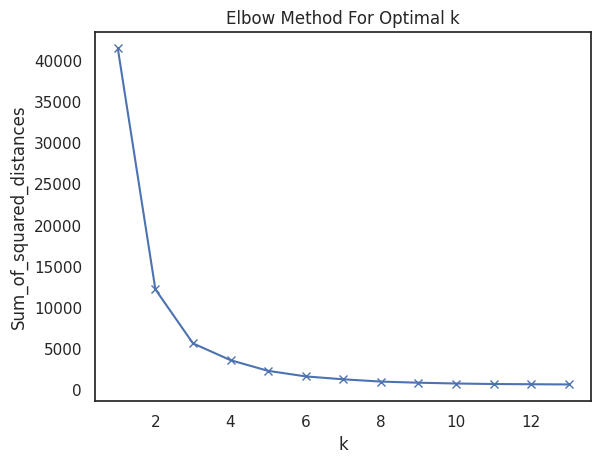

In [15]:
# create an empty list to fill with values later
Sum_of_squared_distances = []

# get a range of numbers from 1 to 14
K = range(1,14)
#for each number in the range 1 to 14
for k in K:
    # create a k-means model with that number of clusters
    # set random state
    km = cluster.KMeans(n_clusters=k, init="random", random_state=123)
    # fit the model using the variables of interest (in this case the proportion of household fuel poor and proportion of car availability)
    km = km.fit(cleaned_data[['Proportion of households fuel poor (%)','prop_car']].values)
    # calculate the sum of the squared distances and add this to the 'Sum_of_squared_distances' list we created earlier
    Sum_of_squared_distances.append(km.inertia_)

# plot the sum of squared distances against the number of clusters
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Run the K-means cluster again with n=4 clusters.

In [16]:
# run the model with 4 clusters
km4 = cluster.KMeans(n_clusters=4,init="random", random_state=123)
km4cls = km4.fit(cleaned_data[['Proportion of households fuel poor (%)','prop_car']].values)
km4cls.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1,
       3, 1, 1, 3, 0, 0, 3, 0, 3, 3, 0, 0, 3, 3, 3, 3, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 3, 3, 1, 1, 0, 0, 3, 1, 1, 3, 0, 0, 3, 0, 3, 0, 0, 3,
       3, 0, 0, 3, 3, 3, 3, 0, 2, 1, 1, 3, 2, 3, 3, 3, 3, 1, 3, 0, 1, 0,
       3, 0, 3, 0, 3, 3, 3, 3, 1, 0, 3, 1, 3, 3, 3, 3, 1, 0, 2, 3, 1, 2,
       1, 3, 0, 0, 3, 0, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 2, 2, 3, 2, 1,
       2, 1, 2, 2, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 3, 0,
       3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 3, 3, 0,
       0, 0, 0, 3, 2, 1, 1, 3, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 0, 1, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 3, 3, 0, 0,
       3, 0, 3, 0, 3, 1, 3, 1, 3, 3, 3, 3, 1, 2, 3, 2, 1, 1, 1, 3, 3, 3,
       3, 1, 3, 3, 0, 1, 0, 3, 3, 0, 3, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 3, 3, 3, 0, 0, 0, 3, 0, 0, 3, 3, 3, 0, 0, 0, 3, 3,
       0, 3, 3, 3, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3,

In [17]:
#  the cluster labels (each LSOA has been assigned a cluster in this array)
cleaned_data['Cluster'] = km4cls.labels_
cleaned_data['Cluster'].head()

0    0
1    1
2    1
3    1
4    2
Name: Cluster, dtype: int32

Create a pair plot visualization to find out the relationship between the variables captured by clustering

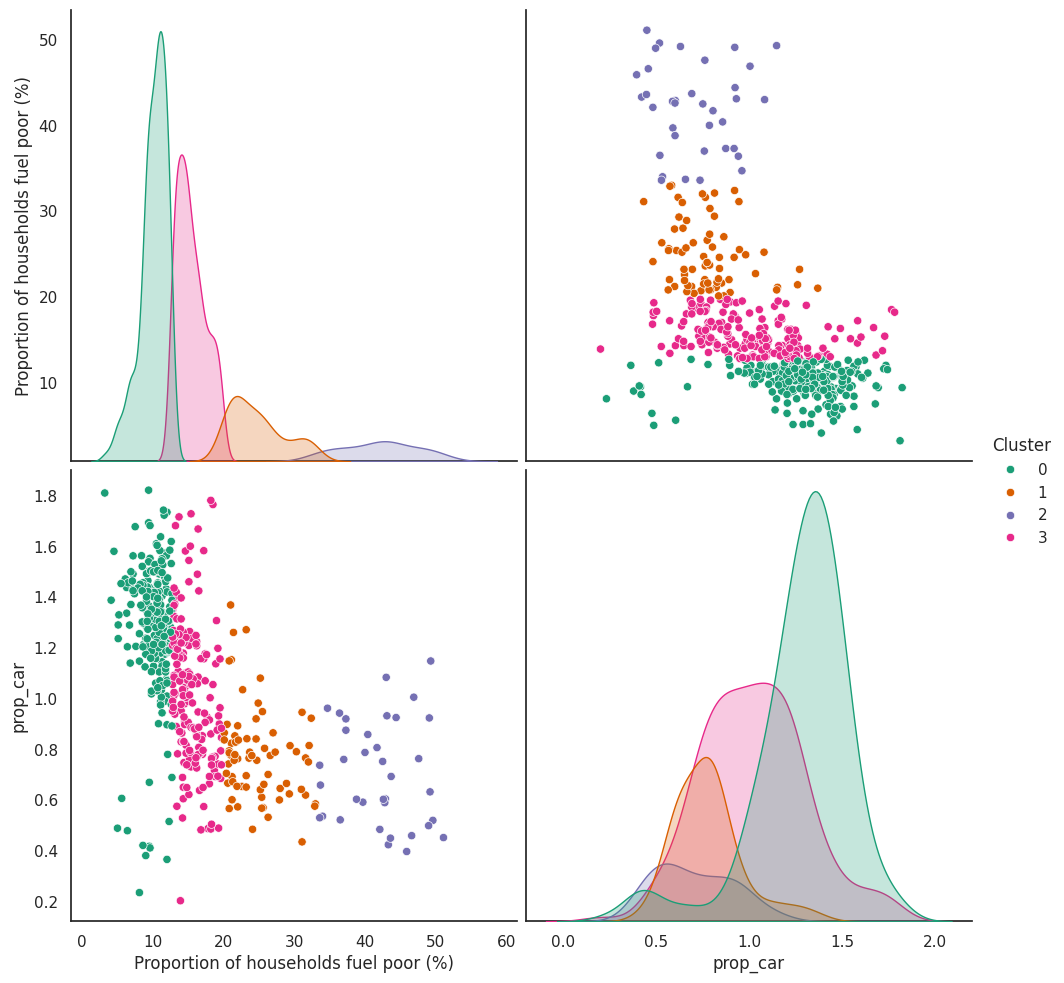

In [18]:
# The pari plot gives us an idea of all the relationships between the points captured by the clustering
sns.pairplot(cleaned_data[['Proportion of households fuel poor (%)','prop_car','Cluster']],
             hue='Cluster',
             palette='Dark2',
            height=5)

Map the clusters to view any spatial relationship(s) between clusters

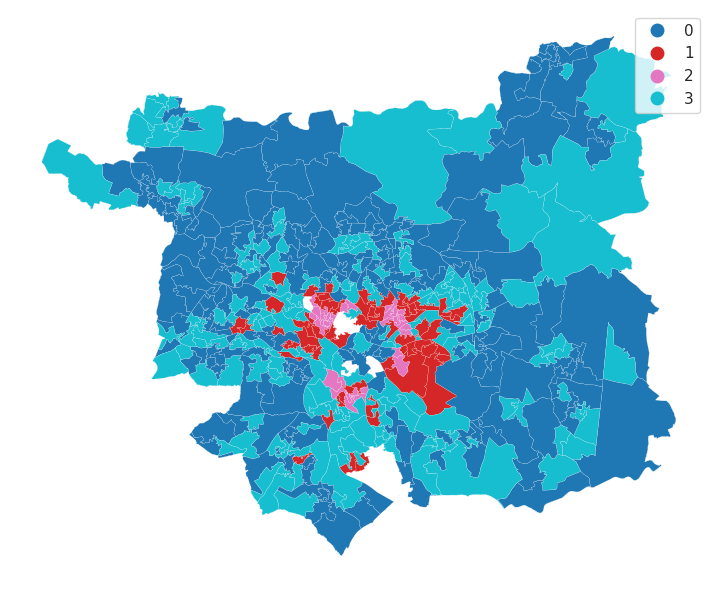

In [19]:
# We can also see that there is a spatial pattern to the clusters when we map them
f, ax = plt.subplots(1, figsize=(9, 9))

cleaned_data.plot(column='Cluster', categorical=True, legend=True, \
         linewidth=0.1, edgecolor='white', ax=ax)

ax.set_axis_off()

plt.show()

Data visualization is a powerful tool to communicate insights, trends, and patterns from complex data sets. Because we are finding the correlation between the twovariables, scatter plot is the best visualization to interpret.A scatter plot is chosen because it allows us to visualize the relationship between two continuous variables, which are "proportion of fuel poor" and "proportion of car owned". This helps in identifying patterns and clusters in the data. The choice of color map ensures that the clusters are visually distinguishable with colors that are perceptually uniform, aiding interpretation.

The Final non-spatial visualization after clusteriing, which clearly show the accociation between the fuel poverty and car or van availability in Leeds through 4 clusters. This generated a linear relationship between them which is the area has severe fuel poverty has less amount of car, and the area has less fuel poverty come with large number of car. Also the car availability is not the only reason due to the fuel poverty, we will learn this further in the future project. Because the project are only contain two variables, which is unable to create more complex non-spatial visualisation, such as faceted bar chart which can show the result more

Text(0.5, 0, 'proportion of households car availability (%)')

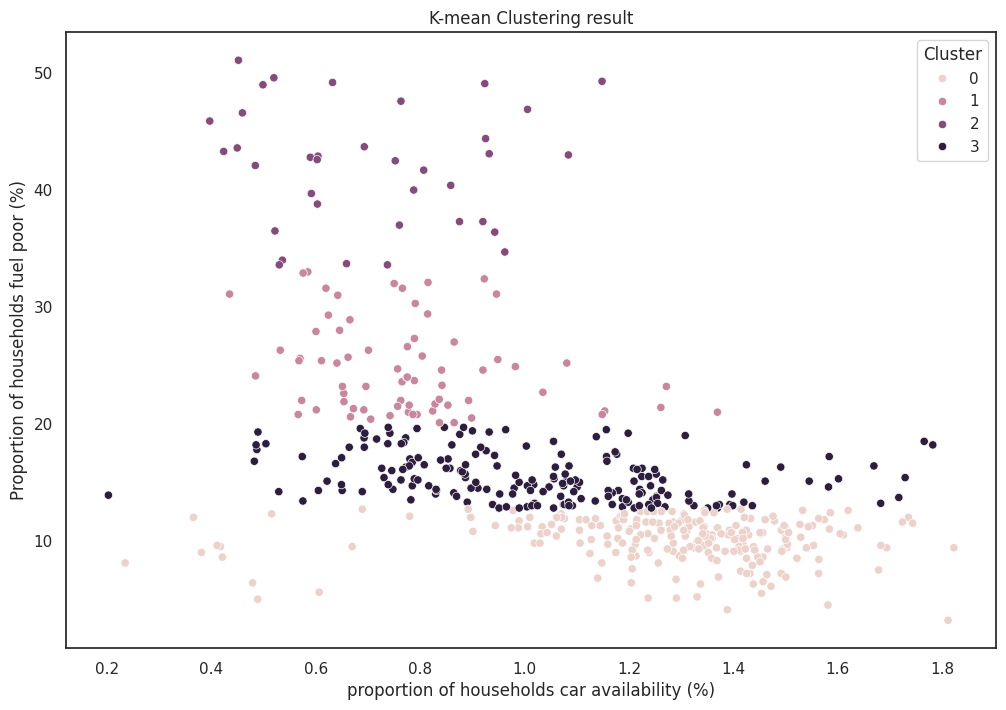

In [20]:
# Plot a scatter plot, where hue is a different cluster

plt.figure(figsize=(12,8))
# plot
sns.scatterplot(x='prop_car', y='Proportion of households fuel poor (%)',hue='Cluster', data=cleaned_data);
plt.title("K-mean Clustering result"),
plt.xlabel('proportion of households car availability (%)')

After adding the cluster description, the final spatial visualization can be generated in map using explore function, which show the same association with the non-spatial visualization, area has severe fuel poverty has less amount of car, and the area has less fuel poverty come with large number of car.

A geographic map is chosen for the spatial visualization because it provides spatial context to the data, especially there are geographic patterns in our dataset. And an explorable map is chosen for creating interactive and customizable maps directly. It allows for easy visualization of geographic data with cluster information.

In [22]:
# add the cluster descriptions
cleaned_data.loc[cleaned_data['Cluster']==0,'Cluster_description']='This area has large amount of car and fuel rich'
cleaned_data.loc[cleaned_data['Cluster']==1,'Cluster_description']='This area has relatively low fuel poverty and relatively low amount of car'
cleaned_data.loc[cleaned_data['Cluster']==2,'Cluster_description']='This area fuel poverty rate are high and car availability is low'
cleaned_data.loc[cleaned_data['Cluster']==3,'Cluster_description']='This area has relatively high amount of car and relatively fuel rich'
# use hex colours to define my own cmap,
# cbind friendly palette colours taken from: https://davidmathlogic.com/colorblind/#%23648FFF-%23785EF0-%23DC267F-%23FE6100-%23FFB000
my_cmap=['#FFB000','#785EF0','#DC267F','#FE6100','#648FFF']
# Plot your cluster descriptions on the map
map =cleaned_data.sort_values('Cluster_description').explore('Cluster_description', categorical =True, cmap=my_cmap)
map.save("cleaned_data.html")
# view map
map

## References
<p><a href="https://datamillnorth.org/dataset/2j70l/fuel-poverty-by-lsoa-england">[1]</a> Department for Energy Security and Net Zero, Fuel poverty by LSOA (England), 2024</p>
<p><a href="https://data-communities.opendata.arcgis.com/datasets/communities::lower-super-output-area-lsoa-imd-2019-osgb1936/about">[2]</a> DLUCH GIS Team, Lower Super Output Area (LSOA) IMD 2019, Ministry of Housing, Communities and Local Government , 2021</p>
<p><a href="https://www.ons.gov.uk/datasets/TS045/editions/2021/versions/1">[3]</a> Office for National Statistics, Car or van availability, 2023</p>
<p><a href="https://github.com/FrancescaPontin/GEOG5990">[4]</a>GEOG5990M course materials</p>
